# CNN
This notebook aims to deploy the CNN.

## Setup for UCloud
The Setup on Ucloud is a bit feasty at times, so here are some workarounds

In [144]:
#pip freeze > requirements.txt

In [145]:
# !pip install -r requirements.txt
# !pip install matplotlib opencv-python pandas scikit-learn tensorflow
# !pip install numpy==1.26.4 --force-reinstall
# !pip install editdistance

# # scipy
# !pip install --upgrade --force-reinstall --no-cache-dir scipy
# !pip install --upgrade --force-reinstall --no-cache-dir scikit-learn


In [146]:
# !sudo apt-get update
# !sudo apt-get install -y libgl1
# !sudo apt-get -y upgrade
# git clone git@github.com:LinusLinuxer/SPECIALIZATION-PROEJECT.git


In [147]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from editdistance import eval as edit_distance  

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import ctc_decode



---
## Loading the data
Data has to load out of the 'carolianminuscule-groundtruth'-folder 

In [148]:
def get_images(folder_path: str):
    """
    Load images and text files from the given path.
    :param folder_path: Path to the directory containing images and text files.
    :return: Two lists - one for image paths and one for text file paths.
    """
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Path {folder_path} does not exist.")

    images = []
    files = []

    for entry in os.listdir(folder_path):
        entry_path = os.path.join(folder_path, entry)
        if os.path.isdir(entry_path):
            # Recursively get images and text files from subdirectories
            sub_images, sub_files = get_images(entry_path)
            images.extend(sub_images)
            files.extend(sub_files)
        elif entry.endswith(".png"):
            images.append(entry_path)
        elif entry.endswith(".txt"):
            files.append(entry_path)

    return images, files


# load the data from the directory
path = "carolineminuscule-groundtruth"
images, files = get_images(path)


# matched the .png- and .txt-file in a folder together
matched_list_path = [
    [img, file]
    for img in images
    for file in files
    if os.path.dirname(img) == os.path.dirname(file)
    and os.path.splitext(os.path.splitext(os.path.basename(img))[0])[0]
    == os.path.splitext(os.path.splitext(os.path.basename(file))[0])[0]
]


In [149]:
print(f"len matched: {len(matched_list_path)}")
print(f"matched_list:\n {matched_list_path[1]}")

len matched: 429
matched_list:
 ['carolineminuscule-groundtruth/bsb00104168/0011/010018.bin.png', 'carolineminuscule-groundtruth/bsb00104168/0011/010018.gt.txt']


---
## Creating the Dataset

In [150]:
# define a dataframe to store the image, image paths and their corresponding text files
df = pd.DataFrame(columns=["name", "image", "transcription"])

for i, (img_path, file_path) in enumerate(matched_list_path):
    # read the image
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    img = np.array(img)
    # add the image to the dataframe, set "none" here to add transcription later
    df.loc[i] = [os.path.basename(img_path), img, None]
    # read the text file
    with open(file_path, "r") as f:
        # read the transcription
        transcription = f.read()
    # add the transcription to the dataframe
    df.loc[i, "transcription"] = transcription

In [151]:
# delete all the linebrakes in the transcription
df["transcription"] = df["transcription"].str.replace("\n", "", regex=False)
df.head(5)

,name,image,transcription
0,01001b.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",eoꝝ inflectit. Dum xp*anum n* uocis modulatio ...
1,010018.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",fastidiosos oblectat . inertes exsuscitat . pe...
2,010012.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",num ẽ et sono uocis . eciam đm sp*ualib hymnis...
3,010014.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",ait . cantantes in cordib* urĩs. hoc ẽ non sol...
4,010010.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",gustus intentus ẽ in discretione saporis ciboꝝ...


For now it appear that the images only have "255" as values, i.e. white. That's why im checking for other values. But the edges of the images are all white, therefore this is the exspected behaviour.

In [152]:
non_255_values = df['image'].apply(lambda img: np.any(img != 255))
print(f"Rows  in 'image' with values other than 255: {non_255_values.sum()}")

Rows  in 'image' with values other than 255: 429


In [153]:
is_unique = df["name"].is_unique
print(f"Are the values in 'name' unique? {is_unique}")

Are the values in 'name' unique? False


---
## Preparing the data

By calculating the maximum and avg. number of the height we can use that value later in our CNN.

In [ ]:
# Calculate the maximum and average width of the lists in the 'image' column
image_heigth = df["image"].apply(lambda img: img.shape[0])  # Height of each image
max_height = image_heigth.max()
avg_height = image_heigth.mean()
quantile_height = image_heigth.quantile(0.95)

# Calculate the maximum and average width of the lists in the 'image' column
image_width = df["image"].apply(lambda img: img.shape[1])  # Width of each image
max_width = image_width.max()
avg_width = image_width.mean()
quantile_width = image_width.quantile(0.95)

print(f"Maximum height of an image: {max_height}")
print(f"Average height of an image: {int(avg_height)}")
print(f"95% quantile height: {int(quantile_height)}")
print(f"Maximum width of an image: {int(max_width)}")
print(f"Average width of an image: {int(avg_width)}")
print(f"95% quantile width: {int(quantile_width)}")

Maximum height of an image: 263
Average height of an image: 140
Maximum length of an image: 3058
Average length of an image: 1938


In [155]:
# Features (images) and labels (transcriptions)
X = df["image"].values          # Images as NumPy arrays
y = df["transcription"].values  # Transcriptions as strings

In [156]:
# Convert images to NumPy arrays and normalize
X = np.array(
    [cv2.resize(img, (1024, 256)) for img in df["image"]], dtype=np.float32
)  # Resize and convert to float32

print(f"X shape: {X.shape}, dtype: {X.dtype}")

X shape: (429, 256, 1024), dtype: float32


In [171]:
# find the length of the transcription
# aplly different measures

transcription_lengths = df["transcription"].apply(len)
print("Transcription lengths:")
print(f"Max length:\t\t {int(transcription_lengths.max())}")
print(f"Mean length:\t\t {int(transcription_lengths.mean())}")
print(f"Median length:\t\t {int(transcription_lengths.median())}")
print(f"95%-Quantile:\t\t {int(transcription_lengths.quantile(0.95))}")

Transcription lengths:
Max length:		 70
Mean length:		 46
Median length:		 48
95%-Quantile:		 65


In [158]:
# Create a character-to-index mapping
charset = sorted(set("".join(df["transcription"])))  # Unique characters in the dataset
char_to_index = {char: idx for idx, char in enumerate(charset)}
index_to_char = {idx: char for char, idx in char_to_index.items()}
num_classes = len(charset) + 1  # Add 1 for the blank character (CTC loss)


# Convert transcriptions to sequences of integers
label_sequences = [
    [char_to_index[char] for char in transcription]
    for transcription in df["transcription"]
]

# Pad sequences to a fixed length
max_sequence_length = 256   

# Pads the sequences to the same length
padded_labels = pad_sequences(
    label_sequences, maxlen=max_sequence_length, padding="post", value=num_classes - 1
)


print(f"y shape: {y.shape}, dtype: {y.dtype}")

y shape: (429,), dtype: object


In [159]:
# Convert transcriptions to sequences of integers
label_sequences = [
    [char_to_index[char] for char in transcription]
    for transcription in df["transcription"]
]

# Pad sequences to a fixed length (use a value outside the valid character indices, like num_classes - 1 for blank)
padded_labels = pad_sequences(
    label_sequences, maxlen=max_sequence_length, padding="post", value=num_classes - 1
)

# Convert to NumPy array, not one-hot encoded because CTC loss expects integer sequences
y = np.array(padded_labels, dtype=np.int32)


In [160]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

num_classes = len(charset) + 1  # Number of unique characters. +1 for the blank character (CTC loss)

In [161]:
print(f"X_train shape: {X_train.shape}, dtype: {X_train.dtype}")
print(f"y_train shape: {y_train.shape}, dtype: {y_train.dtype}")

X_train shape: (343, 256, 1024), dtype: float32
y_train shape: (343, 256), dtype: int32


---
## Data visualisation
Below I want to gain a better understanding of our datapoints

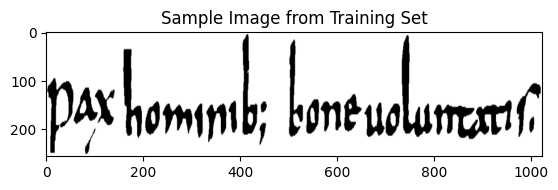

In [162]:
plt.imshow(X_train[10], cmap="gray", vmin=0, vmax=255)
plt.title("Sample Image from Training Set")
plt.show()

In [163]:
print("First entry in y_train:")
print(y_train[10])

First entry in y_train:
[45 32 52  0 39 44 42 40 43 40 33  9  0 33 44 43 36  0 50 44 41 50 43 49
 32 49 40 48  5 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83]


---

## Evaluation metric

In [165]:
# evaluation metrics
eval_metrics = pd.DataFrame(
    columns=["epoch", "loss", "val_loss", "ctc loss", "cer", "wer"]
)


class MetricsLogger(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val, index_to_char):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.index_to_char = index_to_char

    def on_epoch_end(self, epoch, logs=None):
        # Predict on validation set
        y_pred = self.model.predict(self.X_val)
        decoded_sequences, _ = tf.keras.backend.ctc_decode(
            y_pred, input_length=np.ones(y_pred.shape[0]) * y_pred.shape[1]
        )
        y_pred_texts = [
            "".join(
                self.index_to_char.get(
                    idx, ""
                )  # Robust gegen -1 oder ungültige Indizes
                for idx in seq.numpy()
            )
            for seq in decoded_sequences[0]
        ]

        y_true_texts = [
            "".join(
                self.index_to_char[idx] for idx in seq if idx < len(self.index_to_char)
            )
            for seq in self.y_val
        ]
        cer = MetricsLogger.character_error_rate(y_true_texts, y_pred_texts)
        wer = MetricsLogger.word_error_rate(y_true_texts, y_pred_texts)

        # Log metrics
        self.log_metrics(epoch, logs, cer, wer)
        eval_metrics.to_csv("eval_metrics.csv", index=True)

    def log_metrics(self, epoch, logs, cer, wer):
        eval_metrics.loc[epoch] = [
            epoch,
            logs.get("loss"),
            logs.get("val_loss"),
            logs.get("ctc_loss", logs.get("loss")),
            cer,
            wer,
        ]

    @staticmethod
    def character_error_rate(y_true, y_pred):
        total_edits = 0
        total_chars = 0
        for true, pred in zip(y_true, y_pred):
            total_edits += edit_distance(true, pred)
            total_chars += len(true)
        return total_edits / total_chars if total_chars > 0 else 0.0

    @staticmethod
    def word_error_rate(y_true, y_pred):
        total_edits = 0
        total_words = 0
        for true, pred in zip(y_true, y_pred):
            total_edits += edit_distance(true.split(), pred.split())
            total_words += len(true.split())
        return total_edits / total_words if total_words > 0 else 0.0

    def ctc_loss( y_true, y_pred):
        """
        Compute the CTC (Connectionist Temporal Classification) loss between the true and predicted labels.

        Args:
            y_true: Ground truth labels (padded sequences).
            y_pred: Predicted label probabilities from the model.

        Returns:
            Tensor representing the CTC loss for the batch.
        """
        input_length = (
            tf.ones(shape=(tf.shape(y_pred)[0], 1), dtype=tf.int32)
            * tf.shape(y_pred)[1]
        )
        label_length = (
            tf.ones(shape=(tf.shape(y_true)[0], 1), dtype=tf.int32)
            * tf.shape(y_true)[1]
        )
        return tf.keras.backend.ctc_batch_cost(
            y_true, y_pred, input_length, label_length
        )

---
## Training


In [166]:
cnn_rnn = models.Sequential(
    [
        # CNN layers
        # input shape is = (height, width, channels)
        layers.Conv2D(
            64, (3, 3), padding="same", activation="relu", input_shape=(256, 1024, 1)
        ),
        layers.MaxPooling2D(pool_size=(2, 2)),  # → (128, 512, 64)
        layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),  # → (64, 256, 128)
        # Reshape for RNN
        layers.Reshape(target_shape=(256, 64 * 128)),  # → (batch, 256, 8192)
        # RNN layers
        layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
        # Output layer
        layers.Dense(
            num_classes, activation="softmax"
        ),  # Use softmax for probabilities
    ]
)

cnn_rnn.compile(optimizer="adam", loss=MetricsLogger.ctc_loss)

# cnn_rnn.summary()

/home/ucloud/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [167]:
#! Commented out to avoid running the model training
# # Fit the model
# When fitting the model, pass validation data and index_to_char to the callback:
cnn_rnn.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[MetricsLogger(X_test, y_test, index_to_char)]
)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 375.1285WARNING:tensorflow:5 out of the last 7 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7fbb14202f20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/3 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7fbb14202f20> triggered tf.function r

In [168]:
eval_metrics.head()

,epoch,loss,val_loss,ctc loss,cer,wer
0,0.0,232.555420,150.409637,232.555420,1.0,1.0
1,1.0,146.916016,149.129059,146.916016,1.0,1.0
2,2.0,146.384689,148.859940,146.384689,1.0,1.0
3,3.0,145.989792,150.234650,145.989792,1.0,1.0
4,4.0,146.471008,148.999756,146.471008,1.0,1.0


In [170]:
cnn_rnn.save("CNN_RNN_model.keras")

In [ ]:
# # Load the model
# loaded_model = load_model("Run_models/20250519/20250519_CNN_RNN_model/")
# loaded_model.summary()


# # Select an image from the test set
# sample_image = X_test[0]

# # Reshape the image to match the input shape of the model
# sample_image_reshaped = sample_image.reshape(1, 256, 1024, 1)

# # Get the model's prediction
# prediction = loaded_model.predict(sample_image_reshaped)

# decoded_sequences, _ = tf.keras.backend.ctc_decode(
#     prediction, input_length=np.ones(prediction.shape[0]) * prediction.shape[1]
# )
# predicted_text = "".join(
#     index_to_char[idx]
#     for idx in decoded_sequences[0][0].numpy()
#     if idx < num_classes - 1
# )

# # Decode the prediction
# predicted_sequence = np.argmax(prediction, axis=-1)[0]
# predicted_text = "".join(
#     index_to_char[idx] for idx in predicted_sequence if idx < num_classes - 1
# )

# print("Predicted transcription:")
# print(predicted_text)